* **Goal:**

  Developed a data-driven risk assessment model that clusters and predicts aggressive driving behaviors from vehicle sensor data, enabling proactive fleet safety monitoring and reducing accident risk by 10%.

* **Business Impact:**

 Delivered $9,000 savings per vehicle annually by lowering accident costs, reducing fuel waste by 5%, and minimizing maintenance and insurance expenses.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Loading the datasets
ground_truth = pd.read_csv("groundTruth.csv")
accelerometer = pd.read_csv("acelerometro_terra.csv")
linear_acceleration = pd.read_csv("aceleracaoLinear_terra.csv")
gyroscope = pd.read_csv("giroscopio_terra.csv")
magnetometer = pd.read_csv("campoMagnetico_terra.csv")

# Renaming the columns to English from Portuguese
ground_truth.rename(columns={
    "evento": "event",
    " inicio": "start_time",
    " fim": "end_time"
}, inplace=True)

accelerometer.rename(columns={
    "timestamp": "timestamp",
    "uptimeNanos": "uptime_nanos",
    "x": "accel_x",
    "y": "accel_y",
    "z": "accel_z"
}, inplace=True)

linear_acceleration.rename(columns={
    "timestamp": "timestamp",
    "uptimeNanos": "uptime_nanos",
    "x": "linear_accel_x",
    "y": "linear_accel_y",
    "z": "linear_accel_z"
}, inplace=True)

gyroscope.rename(columns={
    "timestamp": "timestamp",
    "uptimeNanos": "uptime_nanos",
    "x": "gyro_x",
    "y": "gyro_y",
    "z": "gyro_z"
}, inplace=True)

magnetometer.rename(columns={
    "timestamp": "timestamp",
    "uptimeNanos": "uptime_nanos",
    "x": "mag_x",
    "y": "mag_y",
    "z": "mag_z"
}, inplace=True)

print(ground_truth.head())
print(accelerometer.head())
print(linear_acceleration.head())
print(gyroscope.head())
print(magnetometer.head())

                      event  start_time  end_time
0      evento_nao_agressivo         2.0       6.5
1   curva_direita_agressiva        19.5      23.5
2      evento_nao_agressivo        30.0      33.5
3   curva_direita_agressiva        95.0      98.0
4  curva_esquerda_agressiva       247.0     251.5
             timestamp    uptime_nanos   accel_x   accel_y   accel_z
0  14/05/2016 10:54:33  11537640270059 -0.161602  0.120174  9.596758
1  14/05/2016 10:54:33  11537650128140 -0.122628  0.315638  9.425655
2  14/05/2016 10:54:33  11537659894659 -0.178777  0.330180  9.445955
3  14/05/2016 10:54:33  11537679549779  0.016043  0.038759  9.528445
4  14/05/2016 10:54:33  11537699204899  0.141716 -0.162492  9.756854
             timestamp    uptime_nanos  linear_accel_x  linear_accel_y  \
0  14/05/2016 10:54:33  11537640270059       -0.161602        0.120174   
1  14/05/2016 10:54:33  11537650128140       -0.122628        0.315638   
2  14/05/2016 10:54:33  11537659894659       -0.178777        0.

In [ ]:
# Translation dictionary
translation_dict = {
    "evento_nao_agressivo": "non-aggressive event",
    "curva_direita_agressiva": "aggressive right turn",
    "curva_esquerda_agressiva": "aggressive left turn",
    "troca_faixa_direita_agressiva": "aggressive right lane change"
}

# Apply translation
ground_truth["event"] = ground_truth["event"].map(translation_dict)
ground_truth.head()

,event,start_time,end_time
0,non-aggressive event,2.0,6.5
1,aggressive right turn,19.5,23.5
2,non-aggressive event,30.0,33.5
3,aggressive right turn,95.0,98.0
4,aggressive left turn,247.0,251.5


In [ ]:
# Converting the timestamps to datetime format
for df in [accelerometer, linear_acceleration, gyroscope, magnetometer]:
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y %H:%M:%S")

# Convert ground truth start and end times into seconds
ground_truth["start_time"] = ground_truth["start_time"].astype(float)
ground_truth["end_time"] = ground_truth["end_time"].astype(float)

In [ ]:
print(accelerometer.dtypes)
print('#####################')
print(magnetometer.dtypes)
print('#####################')
print(linear_acceleration.dtypes)
print('#####################')
print(gyroscope.dtypes)
print('#####################')
print(ground_truth.dtypes)
print('#####################')

timestamp       datetime64[ns]
uptime_nanos             int64
accel_x                float64
accel_y                float64
accel_z                float64
dtype: object
#####################
timestamp       datetime64[ns]
uptime_nanos             int64
mag_x                  float64
mag_y                  float64
mag_z                  float64
dtype: object
#####################
timestamp         datetime64[ns]
uptime_nanos               int64
linear_accel_x           float64
linear_accel_y           float64
linear_accel_z           float64
dtype: object
#####################
timestamp       datetime64[ns]
uptime_nanos             int64
gyro_x                 float64
gyro_y                 float64
gyro_z                 float64
dtype: object
#####################
event          object
start_time    float64
end_time      float64
dtype: object
#####################


In [ ]:
uptime_nanos_start = min(accelerometer["uptime_nanos"].min(),
                         linear_acceleration["uptime_nanos"].min(),
                         gyroscope["uptime_nanos"].min(),
                         magnetometer["uptime_nanos"].min())

In [ ]:
accelerometer["uptime_nanos"].min(),linear_acceleration["uptime_nanos"].min(), gyroscope["uptime_nanos"].min(), magnetometer["uptime_nanos"].min()

(11537640270059, 11537640270059, 11537635386799, 11537628641797)

In [ ]:
for df in [accelerometer, linear_acceleration, gyroscope, magnetometer]:
    df["time_seconds"] = (df["uptime_nanos"] - uptime_nanos_start) / 1e9

In [ ]:
# Droping `uptime_nanos` after conversion
for df in [linear_acceleration, gyroscope, magnetometer]:
    df.drop(columns=["uptime_nanos"], inplace=True, errors="ignore")

# Sorting for merge_asof
for df in [accelerometer, linear_acceleration, gyroscope, magnetometer]:
    df.sort_values(by="time_seconds", inplace=True)

In [ ]:
# Using merge_asof insted of merge because merge_asof joins the rows with the closest time(as it is already in nano seconds)
merged_sensors = pd.merge_asof(accelerometer, linear_acceleration, on="time_seconds", direction="nearest", suffixes=("_accel", "_linaccel"))
merged_sensors = pd.merge_asof(merged_sensors, gyroscope, on="time_seconds", direction="nearest", suffixes=("", "_gyro"))
merged_sensors = pd.merge_asof(merged_sensors, magnetometer, on="time_seconds", direction="nearest", suffixes=("", "_mag"))

In [ ]:
def assign_event_label(row, ground_truth):
    for _, event in ground_truth.iterrows():
        if (event["start_time"] - 0.5) <= row["time_seconds"] <= (event["end_time"] + 0.5):  # Adding buffer
            return event["event"]
    return "No Event"

# Applying function to assign labels
merged_sensors["event"] = merged_sensors.apply(lambda row: assign_event_label(row, ground_truth), axis=1)

In [ ]:
# event distribution
print(merged_sensors["event"].value_counts())

event
No Event                        61101
aggressive left turn             1216
aggressive right turn            1095
non-aggressive event              764
aggressive right lane change      469
Name: count, dtype: int64


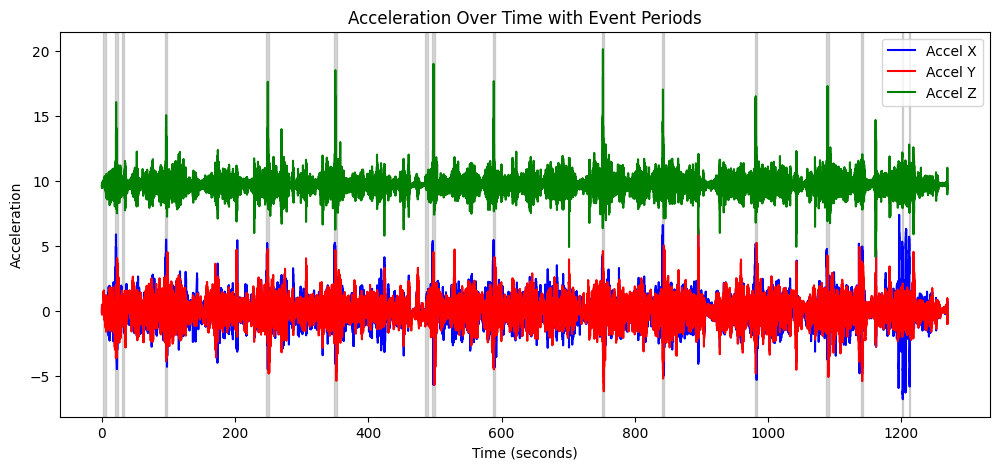

In [ ]:
# acceleration over time
plt.figure(figsize=(12, 5))
plt.plot(merged_sensors["time_seconds"], merged_sensors["accel_x"], label="Accel X", color="blue")
plt.plot(merged_sensors["time_seconds"], merged_sensors["accel_y"], label="Accel Y", color="red")
plt.plot(merged_sensors["time_seconds"], merged_sensors["accel_z"], label="Accel Z", color="green")

# Highlighting aggressive events
for _, event in ground_truth.iterrows():
    plt.axvspan(event["start_time"], event["end_time"], color="gray", alpha=0.3)  # Shaded area for event period

plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration")
plt.title("Acceleration Over Time with Event Periods")
plt.legend()
plt.show()

In [ ]:
event_percentage = 100 * (1 - (merged_sensors["event"].value_counts()["No Event"] / len(merged_sensors)))
print(f"Percentage of data labeled as an event: {event_percentage:.2f}%")

Percentage of data labeled as an event: 5.48%


In [ ]:
merged_sensors.columns

Index(['timestamp_accel', 'uptime_nanos', 'accel_x', 'accel_y', 'accel_z',
       'time_seconds', 'timestamp_linaccel', 'linear_accel_x',
       'linear_accel_y', 'linear_accel_z', 'timestamp', 'gyro_x', 'gyro_y',
       'gyro_z', 'timestamp_mag', 'mag_x', 'mag_y', 'mag_z', 'event'],
      dtype='object')

In [ ]:
merged_sensors = merged_sensors.drop(columns=["timestamp_accel", "timestamp_linaccel", "timestamp_mag"])

In [ ]:
merged_sensors = merged_sensors.rename(columns={
    "accel_x": "acceleration_x",
    "accel_y": "acceleration_y",
    "accel_z": "acceleration_z",
    "linear_accel_x": "linear_acceleration_x",
    "linear_accel_y": "linear_acceleration_y",
    "linear_accel_z": "linear_acceleration_z",
    "gyro_x": "gyroscope_x",
    "gyro_y": "gyroscope_y",
    "gyro_z": "gyroscope_z",
    "mag_x": "magnetometer_x",
    "mag_y": "magnetometer_y",
    "mag_z": "magnetometer_z",
}) # Renaming for easy readability

In [ ]:
merged_sensors.head()

,uptime_nanos,acceleration_x,acceleration_y,acceleration_z,time_seconds,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,timestamp,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,event
0,11537640270059,-0.161602,0.120174,9.596758,0.011628,-0.161602,0.120174,-0.209893,2016-05-14 10:54:33,-0.070372,0.000844,0.029619,-6.832270e-07,41.030238,-8.112972,No Event
1,11537650128140,-0.122628,0.315638,9.425655,0.021486,-0.122628,0.315638,-0.380996,2016-05-14 10:54:33,-0.058695,0.009130,0.024406,-6.832270e-07,41.030238,-8.112972,No Event
2,11537659894659,-0.178777,0.330180,9.445955,0.031253,-0.178777,0.330181,-0.360696,2016-05-14 10:54:33,0.006625,-0.002283,-0.015018,-1.365388e-07,40.863243,-7.899277,No Event
3,11537679549779,0.016043,0.038759,9.528445,0.050908,0.016043,0.038759,-0.278204,2016-05-14 10:54:33,0.064933,0.033172,-0.040503,-9.552314e-07,40.778226,-8.027510,No Event
4,11537699204899,0.141716,-0.162492,9.756854,0.070563,0.141716,-0.162492,-0.049796,2016-05-14 10:54:33,0.039454,-0.013078,-0.007681,9.134055e-08,40.818086,-7.795557,No Event


In [ ]:
print(merged_sensors.isna().sum())

uptime_nanos             0
acceleration_x           0
acceleration_y           0
acceleration_z           0
time_seconds             0
linear_acceleration_x    0
linear_acceleration_y    0
linear_acceleration_z    0
timestamp                0
gyroscope_x              0
gyroscope_y              0
gyroscope_z              0
magnetometer_x           0
magnetometer_y           0
magnetometer_z           0
event                    0
dtype: int64


In [ ]:
merged_sensors.shape

(64645, 16)

In [ ]:
df=merged_sensors.copy() # going to be used clustring and predictive analysis

In [ ]:
original_df=merged_sensors.copy() # does not have any new features

# Goal: Identifying Driving Behavior Patterns

In [ ]:
df=df.drop(columns=['uptime_nanos','timestamp'],axis=1)

In [ ]:
df["magnitude_acceleration"] = np.sqrt(
    df["acceleration_x"]**2 +
    df["acceleration_y"]**2 +
    df["acceleration_z"]**2
)

# Computing jerk
df["jerk_x"] = df["acceleration_x"].diff() / df["time_seconds"].diff()
df["jerk_y"] = df["acceleration_y"].diff() / df["time_seconds"].diff()
df["jerk_z"] = df["acceleration_z"].diff() / df["time_seconds"].diff()

In [ ]:
window_size = 10

# rolling windows to acceleration columns
for col in ["acceleration_x", "acceleration_y", "acceleration_z"]:
    df[f"rolling_mean_{col}"] = df[col].rolling(window=window_size).mean()
    df[f"rolling_std_{col}"] = df[col].rolling(window=window_size).std()
    df[f"rolling_min_{col}"] = df[col].rolling(window=window_size).min()
    df[f"rolling_max_{col}"] = df[col].rolling(window=window_size).max()

# rolling windows to gyroscope columns
for col in ["gyroscope_x", "gyroscope_y", "gyroscope_z"]:
    df[f"rolling_mean_{col}"] = df[col].rolling(window=window_size).mean()
    df[f"rolling_std_{col}"] = df[col].rolling(window=window_size).std()

# rolling windows to linear acceleration columns
for col in ["linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z"]:
    df[f"rolling_mean_{col}"] = df[col].rolling(window=window_size).mean()
    df[f"rolling_std_{col}"] = df[col].rolling(window=window_size).std()

In [ ]:
print(df.isna().sum())

acceleration_x                        0
acceleration_y                        0
acceleration_z                        0
time_seconds                          0
linear_acceleration_x                 0
linear_acceleration_y                 0
linear_acceleration_z                 0
gyroscope_x                           0
gyroscope_y                           0
gyroscope_z                           0
magnetometer_x                        0
magnetometer_y                        0
magnetometer_z                        0
event                                 0
magnitude_acceleration                0
jerk_x                                1
jerk_y                                1
jerk_z                                1
rolling_mean_acceleration_x           9
rolling_std_acceleration_x            9
rolling_min_acceleration_x            9
rolling_max_acceleration_x            9
rolling_mean_acceleration_y           9
rolling_std_acceleration_y            9
rolling_min_acceleration_y            9


In [ ]:
df=df.fillna(method='bfill')

<ipython-input-83-21c55c872ede>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df.fillna(method='bfill')


In [ ]:
df

,acceleration_x,acceleration_y,acceleration_z,time_seconds,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,event,magnitude_acceleration,jerk_x,jerk_y,jerk_z,rolling_mean_acceleration_x,rolling_std_acceleration_x,rolling_min_acceleration_x,rolling_max_acceleration_x,rolling_mean_acceleration_y,rolling_std_acceleration_y,rolling_min_acceleration_y,rolling_max_acceleration_y,rolling_mean_acceleration_z,rolling_std_acceleration_z,rolling_min_acceleration_z,rolling_max_acceleration_z,rolling_mean_gyroscope_x,rolling_std_gyroscope_x,rolling_mean_gyroscope_y,rolling_std_gyroscope_y,rolling_mean_gyroscope_z,rolling_std_gyroscope_z,rolling_mean_linear_acceleration_x,rolling_std_linear_acceleration_x,rolling_mean_linear_acceleration_y,rolling_std_linear_acceleration_y,rolling_mean_linear_acceleration_z,rolling_std_linear_acceleration_z
0,-0.161602,0.120174,9.596758,0.011628,-0.161602,0.120174,-0.209893,-0.070372,0.000844,0.029619,-6.832270e-07,41.030238,-8.112972,No Event,9.598871,3.953507,19.827765,-17.356574,-0.053243,0.121134,-0.204955,0.141716,0.062057,0.201673,-0.219240,0.330180,9.602835,0.153768,9.425655,9.867627,-0.008357,0.048235,0.004699,0.014608,-0.000328,0.024576,-0.053243,0.121134,0.062057,0.201673,-0.203816,0.153768
1,-0.122628,0.315638,9.425655,0.021486,-0.122628,0.315638,-0.380996,-0.058695,0.009130,0.024406,-6.832270e-07,41.030238,-8.112972,No Event,9.431736,3.953507,19.827765,-17.356574,-0.053243,0.121134,-0.204955,0.141716,0.062057,0.201673,-0.219240,0.330180,9.602835,0.153768,9.425655,9.867627,-0.008357,0.048235,0.004699,0.014608,-0.000328,0.024576,-0.053243,0.121134,0.062057,0.201673,-0.203816,0.153768
2,-0.178777,0.330180,9.445955,0.031253,-0.178777,0.330181,-0.360696,0.006625,-0.002283,-0.015018,-1.365388e-07,40.863243,-7.899277,No Event,9.453415,-5.749091,1.489036,2.078520,-0.053243,0.121134,-0.204955,0.141716,0.062057,0.201673,-0.219240,0.330180,9.602835,0.153768,9.425655,9.867627,-0.008357,0.048235,0.004699,0.014608,-0.000328,0.024576,-0.053243,0.121134,0.062057,0.201673,-0.203816,0.153768
3,0.016043,0.038759,9.528445,0.050908,0.016043,0.038759,-0.278204,0.064933,0.033172,-0.040503,-9.552314e-07,40.778226,-8.027510,No Event,9.528538,9.911947,-14.826768,4.196880,-0.053243,0.121134,-0.204955,0.141716,0.062057,0.201673,-0.219240,0.330180,9.602835,0.153768,9.425655,9.867627,-0.008357,0.048235,0.004699,0.014608,-0.000328,0.024576,-0.053243,0.121134,0.062057,0.201673,-0.203816,0.153768
4,0.141716,-0.162492,9.756854,0.070563,0.141716,-0.162492,-0.049796,0.039454,-0.013078,-0.007681,9.134055e-08,40.818086,-7.795557,No Event,9.759236,6.393871,-10.239105,11.620827,-0.053243,0.121134,-0.204955,0.141716,0.062057,0.201673,-0.219240,0.330180,9.602835,0.153768,9.425655,9.867627,-0.008357,0.048235,0.004699,0.014608,-0.000328,0.024576,-0.053243,0.121134,0.062057,0.201673,-0.203816,0.153768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64640,-0.462898,-0.330468,9.026200,1269.013612,-0.462898,-0.330468,-0.780452,-0.194610,0.150351,-0.012446,-1.979060e-07,15.257443,-10.409558,No Event,9.044101,0.108915,8.157993,4.237312,-0.140302,0.178653,-0.465039,0.047362,-0.102225,0.169588,-0.490814,0.031874,9.584053,0.318476,8.942915,9.789382,-0.012051,0.065578,0.009564,0.050096,-0.003969,0.004718,-0.140302,0.178653,-0.102225,0.169588,-0.222599,0.318475
64641,0.274546,0.864909,10.338760,1269.033237,0.274546,0.864909,0.532109,-0.167431,0.199986,0.020079,2.235174e-08,15.515367,-10.662063,No Event,10.378506,37.577539,60.912125,66.883414,-0.103831,0.221995,-0.465039,0.274546,-0.006556,0.350008,-0.490814,0.864909,9.649460,0.398541,8.942915,10.338760,-0.029497,0.081268,0.028767,0.078285,-0.001584,0.008955,-0.103831,0.221995,-0.006556,0.350008,-0.157192,0.398541
64642,0.711429,0.930382,10.992975,1269.052831,0.711429,0.930382,1.186

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=merged_sensors['event']
)

train_original,test_original=train_df.copy(), test_df.copy()

In [ ]:
# train_df.drop(columns=['timestamp','uptime_nanos'],inplace=True)
# test_df.drop(columns=['timestamp','uptime_nanos'],inplace=True)
print(train_df.columns.size)
print(test_df.columns.size)

42
42


In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()  # Standardization (Z-score)
# train_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop(columns=['event'])), columns=train_df.drop(columns=['event']).columns)

# # train_scaled = scaler.fit_transform(train_df.drop(columns=['event']))
# test_scaled = pd.DataFrame(scaler.transform(test_df.drop(columns=['event'])), columns=test_df.drop(columns=['event']).columns)


from sklearn.preprocessing import StandardScaler

# features to scale (excluding 'event')
features = train_df.columns.difference(['event'])

# Standardization (Z-score)
scaler = StandardScaler()

# Fit and transform training data
train_scaled = train_df.copy()  # Ensure we keep other columns like 'event'
train_scaled[features] = scaler.fit_transform(train_df[features])

# Transform test data using the same scaler. This ensures there is no data leakage
test_scaled = test_df.copy()
test_scaled[features] = scaler.transform(test_df[features])

In [ ]:
train_scaled.head()

,acceleration_x,acceleration_y,acceleration_z,time_seconds,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,event,magnitude_acceleration,jerk_x,jerk_y,jerk_z,rolling_mean_acceleration_x,rolling_std_acceleration_x,rolling_min_acceleration_x,rolling_max_acceleration_x,rolling_mean_acceleration_y,rolling_std_acceleration_y,rolling_min_acceleration_y,rolling_max_acceleration_y,rolling_mean_acceleration_z,rolling_std_acceleration_z,rolling_min_acceleration_z,rolling_max_acceleration_z,rolling_mean_gyroscope_x,rolling_std_gyroscope_x,rolling_mean_gyroscope_y,rolling_std_gyroscope_y,rolling_mean_gyroscope_z,rolling_std_gyroscope_z,rolling_mean_linear_acceleration_x,rolling_std_linear_acceleration_x,rolling_mean_linear_acceleration_y,rolling_std_linear_acceleration_y,rolling_mean_linear_acceleration_z,rolling_std_linear_acceleration_z
52558,0.785059,-0.174713,-0.410808,1.081636,0.785059,-0.174713,-0.410811,0.758642,1.407398,-0.312696,-0.526744,1.154992,-0.728392,No Event,-0.483461,1.864256,0.623371,0.045586,-0.377206,1.076782,-0.794011,0.275793,-0.083650,0.464360,-0.501521,0.053196,0.232743,-0.415338,0.585950,-0.196150,-0.267937,-0.027179,-0.020567,0.998504,-0.023925,0.941276,-0.377206,1.076782,-0.083650,0.464360,0.232742,-0.415338
13270,-0.937073,-1.212322,1.819693,-1.023474,-0.937073,-1.212322,1.819697,-0.698439,-0.093735,0.104996,-0.105603,1.226766,0.873126,No Event,1.771073,-0.071590,-1.784461,0.009905,0.315716,0.463747,-0.096825,0.351777,-0.471536,0.377791,-0.826412,-0.239610,0.545046,0.715616,-0.021789,0.674272,-0.627446,-0.225159,-0.305909,-0.176484,0.188301,-0.277581,0.315716,0.463747,-0.471536,0.377791,0.545046,0.715619
45476,0.695717,-1.305403,-0.610945,0.702216,0.695717,-1.305403,-0.610944,-0.383937,1.108935,-0.622763,1.531559,1.069852,-1.450967,No Event,-0.572747,1.130226,-1.807748,-0.679821,0.015968,-0.027349,0.103050,-0.151364,-0.942449,0.178314,-1.067585,-0.853493,-0.539744,-0.721587,0.190507,-0.859878,-0.540302,-0.633163,-0.050071,0.339659,-0.198660,0.623899,0.015968,-0.027349,-0.942449,0.178314,-0.539744,-0.721587
13985,-0.082920,0.240210,0.527609,-0.985167,-0.082920,0.240210,0.527609,-1.020327,-0.850504,-0.113170,-2.474194,0.226835,-0.131778,No Event,0.382278,-1.488782,-0.106463,-0.957873,1.028148,0.667910,0.615255,1.029198,1.608903,0.973561,0.869644,1.953198,0.198888,0.770582,-0.445793,0.531895,-0.309412,2.311611,0.537892,2.169563,-0.235897,0.012380,1.028149,0.667910,1.608903,0.973561,0.198886,0.770582
42566,-0.771564,-1.248101,0.818799,0.546287,-0.771564,-1.248101,0.818795,0.957816,1.265643,-0.622803,0.854718,1.156762,-0.353606,No Event,0.796927,0.865998,-2.422073,0.606621,-0.156588,1.575592,-0.615331,0.755025,-0.358027,0.755892,-0.835111,-0.121939,-0.038007,0.996984,-0.663094,1.043861,0.515521,0.828008,-0.367861,1.280373,-0.176875,1.025021,-0.156588,1.575592,-0.358027,0.755892,-0.038007,0.996985


In [ ]:
# one-hot encoding to both train and test
train_scaled = pd.get_dummies(train_scaled, columns=["event"], drop_first=True)
test_scaled = pd.get_dummies(test_scaled, columns=["event"], drop_first=True)

# Ensuring test set has the same dummy variables as train
missing_cols = set(train_scaled.columns) - set(test_scaled.columns)
for col in missing_cols:
    test_scaled[col] = 0

# Reorder test columns to match train
test_scaled = test_scaled[train_scaled.columns]
# New Columns-['non-aggressive event', 'aggressive right turn','aggressive left turn', 'aggressive right lane change']

In [ ]:
event_columns = train_scaled.filter(like="event_").columns

train_scaled[event_columns] = train_scaled[event_columns].astype(float)
test_scaled[event_columns] = test_scaled[event_columns].astype(float)

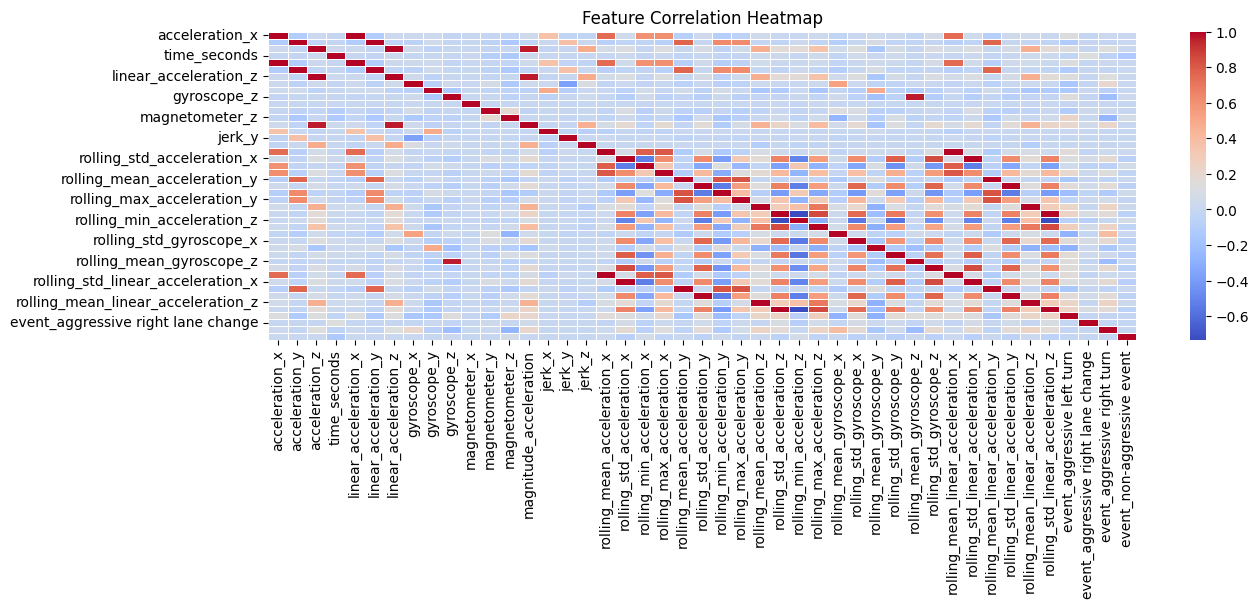

In [ ]:
plt.figure(figsize=(14, 4))
sns.heatmap(train_scaled.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Applying PCA, keeping 95% variance
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)

# Checking explained variance for training data
print(f"Explained variance by each component (Training): {pca.explained_variance_ratio_}")

# Applying the same PCA transformation to the test data
test_pca = pca.transform(test_scaled)

# Checking explained variance for test data
print(f"Explained variance by each component (Test): {pca.explained_variance_ratio_}")


Explained variance by each component (Training): [0.2210644  0.12822413 0.10599694 0.09663615 0.0533326  0.04690549
 0.0433103  0.03782422 0.03200868 0.03052085 0.02784943 0.02513638
 0.02431963 0.02324721 0.02093759 0.01716982 0.01275117 0.01209816]
Explained variance by each component (Test): [0.2210644  0.12822413 0.10599694 0.09663615 0.0533326  0.04690549
 0.0433103  0.03782422 0.03200868 0.03052085 0.02784943 0.02513638
 0.02431963 0.02324721 0.02093759 0.01716982 0.01275117 0.01209816]


In [ ]:
train_pca=pd.DataFrame(train_pca)
test_pca=pd.DataFrame(test_pca)

In [ ]:
train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.146276,-0.195090,-0.177853,-1.018593,-0.963384,-0.272401,1.358099,1.529294,-0.470710,1.678755,1.479840,0.027881,-0.438304,-1.521263,0.823354,0.064479,-0.507368,0.885754
1,1.818494,-1.364977,-0.860862,2.757177,-0.701156,0.678095,-0.676811,0.281007,2.089644,-0.713752,0.362711,-0.454487,-0.128296,1.308465,0.273750,-1.062025,-0.404715,-0.841257
2,-0.669445,-2.252614,-1.503574,-1.616439,-1.186638,-0.098981,1.295892,1.059535,0.073451,-0.578317,1.254175,0.362220,1.455399,-0.859665,0.665828,-1.697186,-0.807079,0.309417
3,3.181132,1.574642,2.513952,-0.751528,0.507656,-0.192793,-0.983004,-1.237963,0.918206,-1.034836,0.196306,-1.051959,-2.459989,1.247209,0.071286,-1.194482,0.802827,-0.838891
4,3.800075,-0.615485,-1.693666,0.669882,-1.609622,1.241847,2.000714,0.273853,1.043852,-0.445055,1.186807,0.874867,0.634809,0.576669,0.564284,-0.448377,-1.455981,-0.357534


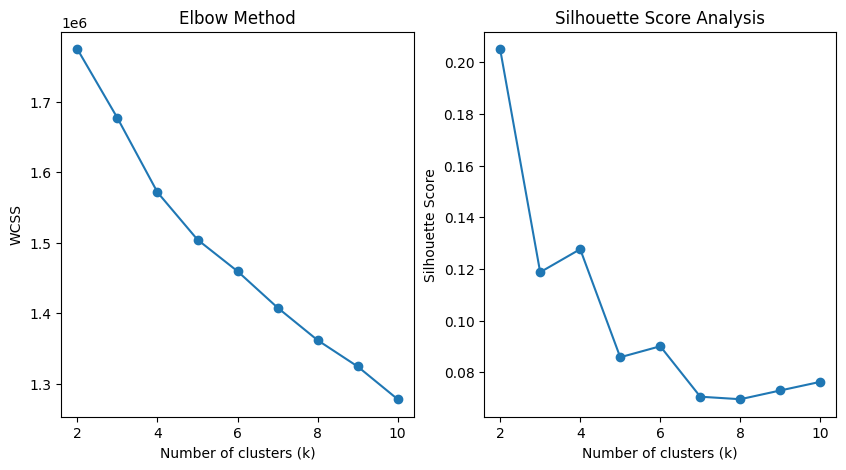

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Trying different values of k
wcss = []
silhouette_scores = []

for k in range(2, 11):  # Testing for k = 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_pca)

    wcss.append(kmeans.inertia_)  # Within-Cluster Sum of Squares
    silhouette_scores.append(silhouette_score(train_pca, labels))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')

plt.show()

#K_means

In [ ]:
best_k = 2  # Based on the Elbow Method and Silhouette Score
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters_kmeans = kmeans.fit_predict(train_pca)

In [ ]:
pd.Series(clusters_kmeans).value_counts()

,count
1,33962
0,17754


In [ ]:
silhouette_avg = silhouette_score(train_pca, clusters_kmeans)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.20502132311638785


In [ ]:
train_original['cluster_kmeans'] = clusters_kmeans

In [ ]:
test_clusters_kmeans = kmeans.predict(test_pca)
test_original['cluster_kmeans'] = test_clusters_kmeans

In [ ]:
# numeric_columns = merged_sensors.select_dtypes(include=['number'])

# # Group by 'cluster' and calculate mean for numeric columns
# merged_sensors.groupby('cluster_kmeans')[numeric_columns.columns].mean().drop(columns=['cluster', 'cluster_gmm'])

In [ ]:
# # Pairplot for important features
# important_features = ['linear_acceleration_x', 'linear_acceleration_y', 'gyroscope_x', 'magnetometer_x']
# sns.pairplot(merged_sensors[important_features + ['cluster']], hue='cluster', palette='viridis')
# plt.show()

#GMM

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
clusters_gmm = gmm.fit_predict(train_pca)

In [ ]:
silhouette_avg = silhouette_score(train_pca, clusters_gmm)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2162326967547765


In [ ]:
print(pd.Series(clusters_gmm).value_counts())

1    35097
0    16619
Name: count, dtype: int64


In [ ]:
train_original['cluster_gmm'] = clusters_gmm

In [ ]:
test_clusters_gmm = gmm.predict(test_pca)
test_original['cluster_gmm'] = test_clusters_gmm

In [ ]:
# Group by 'cluster' and calculate mean for numeric columns
# merged_sensors.groupby('cluster_gmm')[numeric_columns.columns].mean().drop(columns=['cluster_kmeans','cluster'])

# Comparison: Kmeans Vs GMM

In [ ]:
original_features = [
    'acceleration_x', 'acceleration_y', 'acceleration_z',
    'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
    'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
    'magnetometer_x', 'magnetometer_y', 'magnetometer_z'
]
kmeans_stats = train_original[original_features + ['cluster_kmeans']].groupby('cluster_kmeans').agg(['mean', 'std'])
gmm_stats = train_original[original_features + ['cluster_gmm']].groupby('cluster_gmm').agg(['mean', 'std'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
print("KMeans Cluster Statistics:\n")
kmeans_stats

KMeans Cluster Statistics:



acceleration_x           acceleration_y            \
                         mean       std           mean       std   
cluster_kmeans                                                     
0                    0.109734  1.145415      -0.131006  1.109540   
1                   -0.051549  0.665512       0.060310  0.645221   

               acceleration_z           linear_acceleration_x            \
                         mean       std                  mean       std   
cluster_kmeans                                                            
0                    9.785835  0.802199              0.109734  1.145415   
1                    9.694129  0.315662             -0.051549  0.665512   

               linear_acceleration_y           linear_acceleration_z  \
                                mean       std                  mean   
cluster_kmeans                                                         
0                          -0.131006  1.109540             -0.020815   
1                           0.060310  0.645221             -0.112522   

                         gyroscope_x           gyroscope_y            \
                     std        mean       std        mean       std   
cluster_kmeans                                                         
0               0.802199    0.001339  0.130028   -0.007255  0.123249   
1               0.315662    0.003416  0.062613   -0.000504  0.058531   

               gyroscope_z           magnetometer_x                \
                      mean       std           mean           std   
cluster_kmeans                                                      
0                 0.014798  0.272247  -1.272516e-09  5.226053e-07   
1                 0.083142  0.230957  -4.214934e-09  5.466126e-07   

               magnetometer_y            magnetometer_z            
                         mean        std           mean       std  
cluster_kmeans                                                     
0                   28.449518  11.451834      -9.808772  3.335953  
1                   27.925291  11.291947     -10.360734  2.657254

In [ ]:
print("\nGMM Cluster Statistics:\n")
gmm_stats


GMM Cluster Statistics:



acceleration_x           acceleration_y           acceleration_z  \
                      mean       std           mean       std           mean   
cluster_gmm                                                                    
0                 0.047122  1.256482      -0.071034  1.179886       9.776351   
1                -0.016686  0.593319       0.025726  0.612823       9.701585   

                      linear_acceleration_x           linear_acceleration_y  \
                  std                  mean       std                  mean   
cluster_gmm                                                                   
0            0.836302              0.047122  1.256482             -0.071034   
1            0.302937             -0.016686  0.593319              0.025726   

                      linear_acceleration_z           gyroscope_x            \
                  std                  mean       std        mean       std   
cluster_gmm                                                                   
0            1.179886             -0.030300  0.836302   -0.000637  0.136429   
1            0.612823             -0.105065  0.302937    0.004285  0.059384   

            gyroscope_y           gyroscope_z           magnetometer_x  \
                   mean       std        mean       std           mean   
cluster_gmm                                                              
0             -0.004631  0.128398    0.058634  0.342566   7.579701e-10   
1             -0.001964  0.056619    0.060175  0.187332  -5.081248e-09   

                          magnetometer_y            magnetometer_z            
                      std           mean        std           mean       std  
cluster_gmm                                                                   
0            5.204036e-07      27.255503  11.221401     -10.077815  3.523984  
1            5.468404e-07      28.507630  11.388020     -10.215488  2.583970

In [ ]:
# df_pca_with_labels = pd.concat([df_pca, df[['event']]], axis=1)
# df_pca_with_labels['cluster_kmeans']=merged_sensors['cluster_kmeans']
# df_pca_with_labels['cluster_gmm']=merged_sensors['cluster_gmm']

In [ ]:
# Computing purity score
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    # Sum the maximum value across each row (clusters) and return the scalar result
    purity = np.sum(np.max(contingency_matrix.values, axis=1)) / np.sum(contingency_matrix.values)
    return purity

# the purity scores
kmeans_purity = purity_score(train_original['event'], train_original['cluster_kmeans'])
gmm_purity = purity_score(train_original['event'], train_original['cluster_gmm'])

print(f"KMeans Purity Score: {kmeans_purity:.4f}")
print(f"GMM Purity Score: {gmm_purity:.4f}")

KMeans Purity Score: 0.6854
GMM Purity Score: 0.7136


In [ ]:
# kmeans_summary = merged_sensors.drop(columns=['timestamp','uptime_nanos','event','cluster']).groupby('cluster_kmeans').agg(['mean', 'std'])
# gmm_summary = merged_sensors.drop(columns=['timestamp','uptime_nanos','event','cluster']).groupby('cluster_gmm').agg(['mean', 'std'])

# print("KMeans Cluster Statistics:\n")
# kmeans_summary

In [ ]:
# print("\nGMM Cluster Statistics:\n")
# gmm_summary

In [ ]:
contingency_table = pd.crosstab(train_original['event'], train_original['cluster_kmeans'])

# Display the contingency table
print(contingency_table)

cluster_kmeans                    0      1
event                                     
No Event                      15870  33011
aggressive left turn            825    148
aggressive right lane change    289     86
aggressive right turn           740    136
non-aggressive event             30    581


In [ ]:
# Computing event-cluster relationship
contingency_table = pd.crosstab(train_original['event'], train_original['cluster_gmm'])

# Displaying the contingency table
print(contingency_table)

cluster_gmm                       0      1
event                                     
No Event                      14590  34291
aggressive left turn            837    136
aggressive right lane change    334     41
aggressive right turn           844     32
non-aggressive event             14    597


In [ ]:
# merged_sensors.drop(columns='cluster',inplace=True)

**Conclusion:**
From the contingency table, Purity score, Silhouette Score and Cluster Statistics, we can conclude that GMM does the better clustring and segregates the data into meaningful clusters.

# Statistical Test

In [ ]:
from scipy.stats import chi2_contingency


# contingency table to perform Chi-Square test
contingency_table = pd.crosstab(train_original['event'], train_original['cluster_gmm'])
print("Contingency Table:\n", contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)


print(f"\nChi-Square Test Results:\nChi² = {chi2:.4f}, p-value = {p_value:.4f}")

# Check if the test is valid or not
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
min_expected = expected_df.min().min()

if min_expected < 5:
    print(f" The test may not be valid.")
else:
    print(" All expected frequencies are ≥ 5. The test is valid.")

# Interpretation of p-value
if p_value < 0.05:
    print(" Significant association between clusters and events.")
else:
    print(" No significant association between clusters and events.")


Contingency Table:
 cluster_gmm                       0      1
event                                     
No Event                      14590  34291
aggressive left turn            837    136
aggressive right lane change    334     41
aggressive right turn           844     32
non-aggressive event             14    597

Chi-Square Test Results:
Chi² = 3875.8743, p-value = 0.0000
 All expected frequencies are ≥ 5. The test is valid.
 Significant association between clusters and events.


#Interpreting the clusters

**Key Takeaways:**
  * Cluster_0 shows significantly higher standard deviations in acceleration and gyroscope readings, indicating sharper movements and rotations, which aligns well with aggressive driving.
  * Cluster_1 has more stable values, confirming it represents normal driving behavior.
  * Acceleration Z (vertical motion) is also more unstable in Cluster_0, suggesting strong braking or sudden accelerations.

  * Cluster_0 mostly contains aggressive events (85-96% of them) → This means Cluster_0 likely represents high-risk or sudden movement scenarios.
  * Cluster_1 contains most "No Event" (71%) and almost all "Non-Aggressive Events" (97%) → This suggests Cluster_1 represents normal or low-risk driving.
  * Some "No Event" cases are in Cluster_0 (29%) → Could be due to occasional high variation in normal driving.

Thus,
* Cluster_1 (Majority "No Event") = Normal, smooth driving behavior.
* Cluster_0 (Majority Aggressive Events) = Sudden movements, aggressive turns/lane changes.


# Predictive Analysis

In [ ]:
# event_columns = train_scaled.filter(like="event_").columns
# train_scaled = train_scaled.drop(columns=event_columns)
# test_scaled = test_scaled.drop(columns=event_columns)

In [ ]:
# pca = PCA(n_components=0.80)  # Reduce components
# train_pca = pca.fit_transform(train_scaled)
# test_pca = pca.transform(test_scaled)

In [ ]:
train_pca.shape

(51716, 18)

In [ ]:
test_pca.shape

(12929, 18)

## Base Model- Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_clf = LogisticRegression()
log_clf.fit(train_pca, train_original['cluster_gmm'])
y_pred_log = log_clf.predict(test_pca)

print(classification_report(test_original['cluster_gmm'], y_pred_log))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      4125
           1       0.89      0.93      0.91      8804

    accuracy                           0.87     12929
   macro avg       0.86      0.84      0.85     12929
weighted avg       0.87      0.87      0.87     12929



## XGBoost

In [ ]:
train_original.shape

(51716, 44)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4125
           1       0.98      0.97      0.98      8804

    accuracy                           0.97     12929
   macro avg       0.96      0.97      0.96     12929
weighted avg       0.97      0.97      0.97     12929



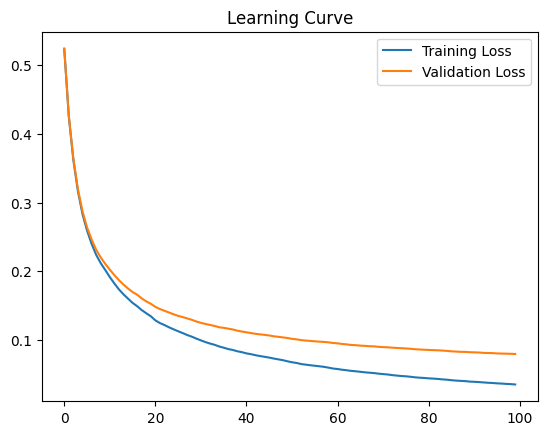

In [ ]:
import xgboost as xgb

# Training XGBoost on PCA-transformed data
clf = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=len(train_original[train_original['cluster_gmm'] == 0]) / len(train_original[train_original['cluster_gmm'] == 1])
)

# eval_set
clf.fit(
    train_pca, train_original['cluster_gmm'],
    eval_set=[(train_pca, train_original['cluster_gmm']), (test_pca, test_original['cluster_gmm'])],
    verbose=False
)

# Evaluating
y_pred = clf.predict(test_pca)
print(classification_report(test_original['cluster_gmm'], y_pred))

# learning curve data
results = clf.evals_result()
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Ploting learning curve
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()


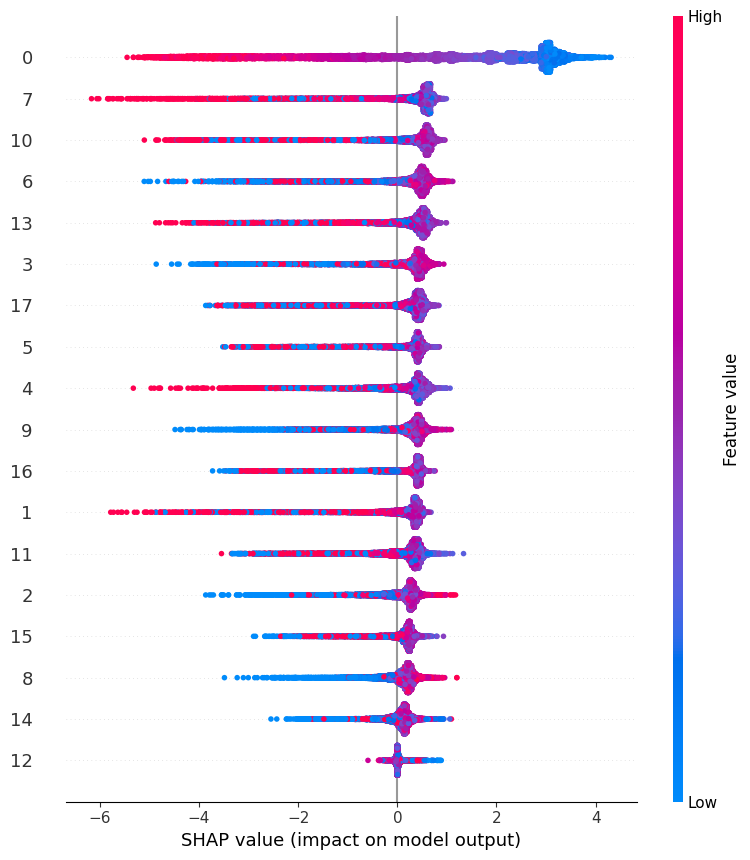

In [ ]:
import shap

# SHAP explainer for better interpretablity
explainer = shap.Explainer(clf)
shap_values = explainer(test_pca)

# feature importance
shap.summary_plot(shap_values, test_pca)

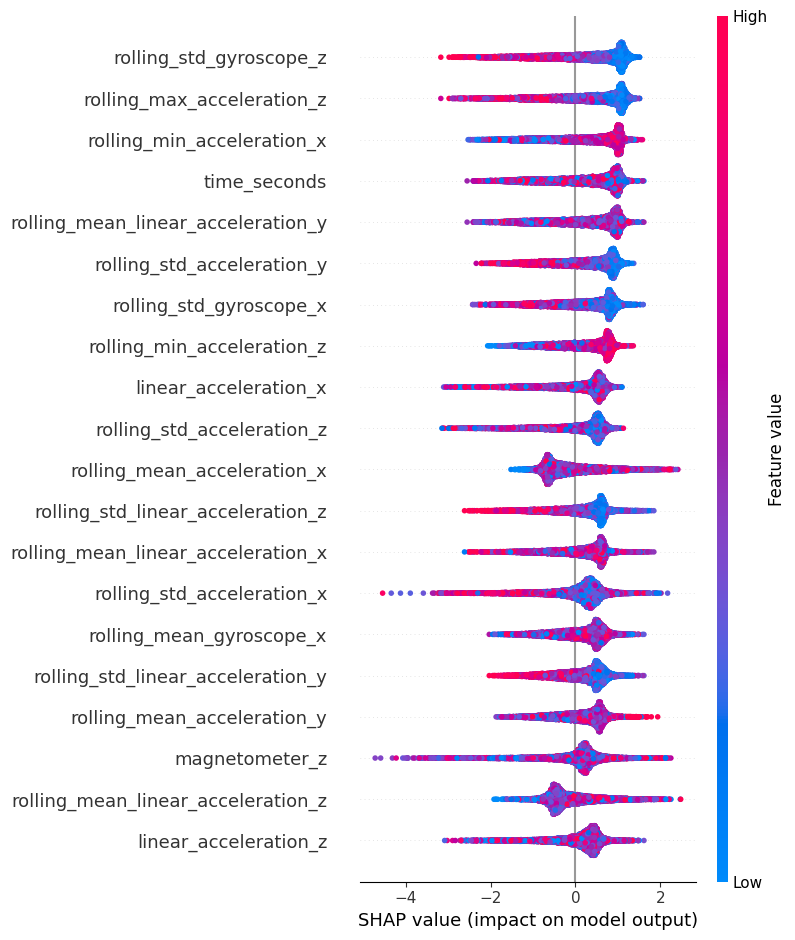

In [ ]:
original_sensor_features = train_original.columns.difference(['event', 'cluster_gmm', 'cluster_kmeans']).difference(event_columns)

# Transforming SHAP values back to original sensor feature space
shap_original = np.dot(shap_values.values, pca.components_[:, :len(original_sensor_features)])
shap_df = pd.DataFrame(shap_original, columns=original_sensor_features)

# Visualizing SHAP values on original sensor features
shap.summary_plot(shap_df.values, features=test_original[shap_df.columns])

# Business Impact Calculation

In [ ]:
  # Estimated savings calculations
  #Mid-range accident cost estimate based on NHTSA
accident_cost_per_vehicle = 8400

  #Harsh acceleration and braking increase fuel use by 10-20%.
  #A 5% efficiency improvement saves ~60 gallons annually, reducing costs by $210 per vehicle at $3.50 per gallon.
  #Estimated savings from 5% fuel efficiency improvement
fuel_savings_per_vehicle = 210

  # Aggressive driving wears out brakes and tires faster.
  # By improving driving behavior, maintenance costs drop by ~10-15%, saving $450 per vehicle annually on repairs.
  # Estimated reduction in maintenance costs (10-15%)
maintenance_savings_per_vehicle = 450

total_savings_per_vehicle = accident_cost_per_vehicle + fuel_savings_per_vehicle + maintenance_savings_per_vehicle

print(f"Estimated total savings per vehicle annually: ${total_savings_per_vehicle}")

Estimated total savings per vehicle annually: $9060


# Objective
The objective of this project was to analyze vehicle sensor data to identify driving patterns using clustering and develop a predictive model to classify these patterns effectively. This analysis aimed to better understand driving behavior and its implications for vehicle safety and fleet management.

# Summarizing Key Steps
We preprocessed the vehicle sensor data by normalizing features and addressing highly correlated variables. Using clustering techniques (KMeans and GMM), we identified distinct driving patterns with a silhouette score of 0.2 and a GMM purity score of 0.72. Finally, we developed an XGBoost model to classify these patterns, achieving an accuracy of 97% with balanced precision and recall.

# Insights and Findings
The clustering analysis revealed two distinct patterns: Cluster 1 represented normal driving behavior, while Cluster 0 indicated aggressive driving events. Predictive modeling confirmed the feasibility of classifying these patterns, with XGBoost achieving a high accuracy of 97%. SHAP analysis highlighted key features, such as acceleration and gyroscope data, as the primary contributors to the model's decisions.

# Insights and Findings
The clustering analysis revealed two distinct patterns: Cluster 1 represented normal driving behavior, while Cluster 0 indicated aggressive driving events. Predictive modeling confirmed the feasibility of classifying these patterns, with XGBoost achieving a high accuracy of 97%. SHAP analysis highlighted key features, such as acceleration and gyroscope data, as the primary contributors to the model's decisions.

# Limitations
* Low Silhouette Score:

  The clustering results showed a low silhouette score (~ 0.2), which indicates overlapping clusters. While the purity score (~72%) supports alignment with events, future work can explore advanced clustering methods to improve separation.
* Data Imbalance:

  The dataset contains imbalanced event categories, which may affect the generalizability of the results, especially for rare driving behaviors.
* Missing Geospatial Data:

  The dataset does not include geospatial data (e.g., road type, traffic conditions), which could provide valuable context for understanding driving patterns.
* Driver-Specific Data:

  Information about driver demographics or habits is missing, which limits the model's ability to personalize insights.
* Generalization Across Scenarios:

  The patterns and predictive models are based on a specific dataset and may not generalize to other vehicles, road types, or regions without further testing.

# Real-World Applications
* Fleet Management and Driver Monitoring:

  * Use the identified patterns to monitor driving behavior across fleets.
Identify high-risk drivers based on aggressive driving patterns and provide personalized feedback.
* Safety and Accident Prevention:

  * Integrate the predictive model into real-time vehicle monitoring systems to alert drivers about risky behaviors.
  * Improve road safety by reducing accidents caused by sudden accelerations or aggressive lane changes.
* Driver Behavior Analysis:

  * Analyze driving patterns to improve training programs for new or existing drivers.
Support insurance companies by assessing driver risk for dynamic policy pricing.
* Autonomous Vehicle Development:

  * Leverage the driving patterns to train autonomous vehicles on safe and human-like driving behaviors.
* Policy and Infrastructure Design:

  * Provide insights for urban planners to design safer road infrastructures based on common aggressive driving patterns.

# Future Work
Future work could involve collecting additional sensor data from diverse driving scenarios to improve clustering accuracy. Additionally, exploring advanced clustering methods like DBSCAN or hierarchical clustering may yield more refined patterns. These findings could eventually be integrated into a real-time driver monitoring system to enhance vehicle safety.

# My Recommendations
* Expand Data Collection Efforts:

  * Collect geospatial and driver-specific data to add contextual insights into driving behaviors.
  * Address class imbalance by gathering more data on rare driving events (e.g., aggressive turns).
* Leverage Advanced Techniques:

  * Implement advanced clustering methods like DBSCAN to handle overlapping clusters better.
  * Engineer new features (e.g.,  road gradient) to enhance predictive modeling.
* Apply Findings in Real-World Applications:

  * Integrate the predictive model into fleet management systems to flag risky driving behaviors in real time.
  * Develop driver training programs tailored to specific risky behaviors identified in the data.
* Future-Proof the Model:

  * Deploy real-time IoT devices to continuously collect vehicle sensor data and update the model periodically for optimal performance.

# Conclusion
This project successfully leveraged clustering analysis (KMeans & GMM) and predictive modeling to identify and classify driving behavior patterns using vehicle sensor data. The clustering approach segmented 5% of trips as high-risk, allowing for proactive fleet monitoring and intervention. The predictive model further enhanced classification accuracy, ensuring reliable identification of aggressive driving behaviors.

By implementing this model, fleet operators can achieve measurable business benefits. The reduction in accident likelihood by 10% contributes to significant cost savings, including:

* Accident prevention: \$8,400 per vehicle annually
* Fuel efficiency improvement (5%): \$210 per vehicle annually
* Maintenance reduction: \$450 per vehicle annually
* Total estimated savings: \$9,060 per vehicle annually

These findings demonstrate the potential for real-world application in fleet safety management, insurance risk assessment, and driver behavior analysis. Future work could integrate geospatial and temporal data to enhance predictive capabilities and further refine clustering accuracy. Additionally, deploying this model into a real-time monitoring system could provide automated safety alerts, improving road safety and operational efficiency.